In [ ]:
#export
import re
import picos
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from collections.abc import Iterable

from bounce.utils import arrayfy, array_in_list

In [ ]:
# default_exp hamiltonian

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Hamiltonian

> The hamiltonian class contains all the information defining the physical problem.

The Hamiltonian contains all the information about the problem. In physical systems it contains both the information about the topology, e.g., underlying `Graph`, and the interactions between parties. With the Hamiltonian, we build the semidefinite program (SdP) that we solve to obtain the bounds and costs (reward) for the agents. 

We call these classes Hamiltonians because we are bounding the ground state energy. However, this can be any object defining a problem in an appropiate way for the respective SdP solver.  

## Graph

In [ ]:
#export
class Graph:
    def __init__(self, nodes, edges):
        self.nodes, self.edges = nodes, edges
        
    @property
    def n_nodes(self): return len(self.nodes)
    
    @property
    def n_edges(self): return len(self.edges)

We define the structure of the problem with a `Graph`, upon which we introduce the interactions. In order to create a `Graph`, we need to provide a list of nodes and edges, which are the links between nodes. 

In [ ]:
nodes, edges = np.array([0, 1, 2]), [np.array([0, 1]), np.array([0, 2])]
g = Graph(nodes, edges)

In [ ]:
assert (g.nodes == nodes).all()
assert np.all([e_graph == e for e_graph, e in zip(g.edges, edges)])

Furthermore, `Graph`s provide some useful properties that provide useful information about the graph. 

In [ ]:
assert g.n_nodes == len(nodes)
assert g.n_edges == len(edges)

We have predefined some common graph structures in typical physical systems, such as a one-dimensional chain or a two-dimensional square lattice, both with or without periodic boundary conditions (denoted as `pbc`). However, notice that implementing graphs allows us to tackle problems with arbitrary dimensions and connectivities. 

In [ ]:
#export
class Chain1D(Graph):
    def __init__(self, N, pbc=True):
        "Create a one-dimensional chain of `N` nodes and periodic boundary conditions `pbc`."
        nodes = np.arange(N)
        edges = [np.sort([i, (i+1)%N]) for i in range(N if pbc else N-1)]
        super().__init__(nodes, edges)
        self.layout = nx.circular_layout

In [ ]:
chain = Chain1D(6)
chain.nodes, chain.edges

(array([0, 1, 2, 3, 4, 5]),
 [array([0, 1]),
  array([1, 2]),
  array([2, 3]),
  array([3, 4]),
  array([4, 5]),
  array([0, 5])])

In [ ]:
assert (chain.nodes == np.arange(6)).all()
edges = [np.sort([i, (i+1)%6]) for i in range(6)]
assert np.all([e_chain == e for e_chain, e in zip(chain.edges, edges)])

In [ ]:
#export
class SquareLattice(Graph):
    def __init__(self, N, M, pbc=True):
        "Create a NxM square lattice with periodic boundary conditions `pbc`."
        self.n_rows, self.n_cols, self.pbc = N, M, pbc
        nodes = np.arange(N*M)
        edges = []
        for i in range(N):
            for j in range(M):
                n = i*M + j
                # Horizontal edges
                if pbc or j != M-1: 
                    n_h = i*M + (j+1)%M
                    edge = np.sort([n, n_h])
                    if not array_in_list(edge, edges): edges.append(edge)
                # Vertical edges
                if pbc or i != N-1:
                    n_v = ((i+1)%N)*M + j
                    edge = np.sort([n, n_v])
                    if not array_in_list(edge, edges): edges.append(edge)           
        super().__init__(nodes, edges)
    
    def layout(self, G):
        "Returns plot positions for a `networkx.Graph` depicting the lattice."
        pos_x = np.linspace(-1, 1, self.n_cols)
        pos_y = np.linspace(1, -1, self.n_rows)
        if self.pbc:
            dy, dx = 1/self.n_rows, 1/self.n_cols
            pos = {}
            for n in G.nodes:
                row, col = n//self.n_cols, n%self.n_cols
                x, y = pos_x[col], pos_y[row]
                left, right = col == 0, col == self.n_cols - 1
                top, bottom = row == 0, row == self.n_rows - 1 
                if not left and not right: y -= dy
                if not top and not bottom:
                    if left:    x -= dx
                    elif right: x += dx
                pos[n] = np.array([x, y])
            return pos
        else: 
            return {n: np.array([pos_x[n%self.n_cols], pos_y[n//self.n_cols]]) for n in G.nodes}

In [ ]:
lattice = SquareLattice(3, 4, pbc=False)

In [ ]:
lattice.edges

[array([0, 1]),
 array([0, 4]),
 array([1, 2]),
 array([1, 5]),
 array([2, 3]),
 array([2, 6]),
 array([3, 7]),
 array([4, 5]),
 array([4, 8]),
 array([5, 6]),
 array([5, 9]),
 array([6, 7]),
 array([ 6, 10]),
 array([ 7, 11]),
 array([8, 9]),
 array([ 9, 10]),
 array([10, 11])]

## Hamiltonian

In [ ]:
#export
class Hamiltonian:
    
    x = picos.Constant('x', [[0, 1], [1, 0]])
    y = picos.Constant('y', [[0, -1j], [1j, 0]])
    z = picos.Constant('z', [[1, 0], [0, -1]])
    Id = picos.Constant('Id', [[1, 0], [0, 1]])
    
    def __init__(self, graph, interactions):
        "Create a Hamiltonian over a graph with defined interactions."
        self.graph, self.interactions = graph, interactions
        self.name = 'base'
        
    def to_sdp(self):
        "Outputs the necessary information for the `SdPSolver`."
        return self.interactions
    
    def draw(self, figsize=(8,6), cmap=plt.cm.viridis):
        "Conceptual drawing of the system."
        G = nx.Graph()            
        G.add_nodes_from([(node.item(), {'w': self._get_weight(w)}) 
                          for node, w in self.interactions if len(node) == 1])
        G.add_edges_from([(*edge.tolist(), {'w': self._get_weight(w)}) 
                          for edge, w in self.interactions if len(edge) == 2])
        
        try: 
            pos = self.graph.layout(G)
        except:
            pos = nx.kamada_kawai_layout(G)
        plt.figure()
        node_weights = [d['w'] for _, d in G.nodes(data=True)]
        edge_weights = [d['w'] for _, _, d in G.edges(data=True)]
        nx.draw_networkx_nodes(G, pos, node_color=node_weights, vmin=min(node_weights),
                               vmax=max(node_weights), cmap=cmap)
        for u, v, w in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, width=4, edgelist=[(u, v)],
                                   alpha=np.abs(w['w'])/max(np.abs(edge_weights)))
        nx.draw_networkx_labels(G, pos, font_color='w');
        
    @staticmethod
    def _get_weight(expression):
        "Extracts the real or complex weight from a `picos.ComplexAffineExpression`."
        try:    
            string = re.findall('\d+\.?\d*[j]?', expression.string)[0]
            return complex(string) if string[-1] == 'j' else float(string)
        except: return 1.
        
    def __deepcopy__(self, memo):
        """Workaround to deepcopy Hamiltonians as there is an issue deepcopying `picos.Constant`.
        We deepcopy everything and only shallow copy the `Hamiltonian.interactions`. This does not
        afect our pipeline, as we not modify any parameters, we'd rather make a new `Hamiltonian`,
        but we do need to deepcopy environments containing Hamiltonians."""
        cls = self.__class__
        new = cls.__new__(cls)
        for k, v in self.__dict__.items():
            setattr(new, k, deepcopy(v) if k != 'interactions' else copy(v))
        return new

Once we have laid out the topology of the problem, we can define the `interactions` happening in the system. These, together with the underlying `Graph`, define a `Hamiltonian`. The `interactions` come in the form of a list of tuples indicating the support and the interaction term `[(support, term)]`. We describe the terms using Pauli matrices $\sigma^x, \sigma^y, \sigma^z$ and the identity. Given that these are the variables that the `SDPSolver` uses to instantiate and solve the optimization problem, we need to write them in terms of `picos` varibales. We provide the variables `x`, `y`, `z`, `Id` within the `Hamiltonian` class to ease the process of defining Hamiltonians for new problems.    

For instance, in the case of non-interacting qubits with a transverse field, described by $H = \sum_i\sigma^x_i$, the interactions would be `[(0, x), (1, x), ...]`. On an Ising-like Hamiltonian, such as $H=J\sum_i\sigma^z_i\sigma^z_{i+1} + B\sum_i\sigma^x_i$, we have to account for the tensor product $\sigma^z_i\sigma^z_{i+1}$, which in the picos library is performed with the `@` operator. Hence, we would define the interactions as `[(0, B*x), (1, B*x), ..., ([0, 1], J*z@z), ([1, 2], J*z@z), ...]`. In fact, the supports should be `np.ndarrays`, e.g., `np.array([0, 1])`, which we take from the `Graph.edges`, and we should access the Pauli variables from the `Hamiltonian` with `self`, e.g., `self.x`. 

Finally, in order to keep a consistent file naming, we provide the Hamiltonians with a `name` property that is a string naming the model. We show some examples below.  

### Ising model
Let's see how to implement a transverse field Ising Hamiltonian and instantiate it in the onedimensional chain. 

In [ ]:
#export
class LocalHamiltonian(Hamiltonian):
    def __init__(self, graph, interactions, *aux_args):
        """Local Hamiltonian with two-body interactions. This class defines a structure for 2-local
        Hamiltonians of the form cls(graph, one_body_amplitudes, two_body_amplitudes, *aux_args).
        This allows us to serialize Hamiltonians with the __reduce__ method, which we do not want
        to explicitly define for every new Hamiltonian. Let us know if you find any better
        solution to this."""
        super().__init__(graph, interactions)
        self.aux_args = aux_args
        
    def __reduce__(self):
        aux_args = self.aux_args if hasattr(self, 'aux_args') else []
        one_body = [self._get_weight(term) for edge, term in self.interactions if len(edge) == 1]
        two_body = [self._get_weight(term) for edge, term in self.interactions if len(edge) == 2]
        return (self.__class__, (self.graph, one_body, two_body, *aux_args))

In [ ]:
#exports
class IsingHamiltonian(LocalHamiltonian):
    def __init__(self, graph, field, coupling):
        field, coupling = arrayfy(field, graph.n_nodes), arrayfy(coupling, graph.n_edges)
        one_body_terms = [(np.array([n]), field[n]*self.x) for n in graph.nodes]
        two_body_terms = [(edge, coupling[e]*self.z@self.z) for e, edge in enumerate(graph.edges)]
        interactions = one_body_terms + two_body_terms
        super().__init__(graph, interactions)
        self.name = 'ising'        

In [ ]:
b, j = 0.75, 2.5
H_ising = IsingHamiltonian(chain, b, j)

In [ ]:
H_ising.interactions

[(array([0]), <2×2 Real Constant: 0.75·x>),
 (array([1]), <2×2 Real Constant: 0.75·x>),
 (array([2]), <2×2 Real Constant: 0.75·x>),
 (array([3]), <2×2 Real Constant: 0.75·x>),
 (array([4]), <2×2 Real Constant: 0.75·x>),
 (array([5]), <2×2 Real Constant: 0.75·x>),
 (array([0, 1]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([1, 2]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([2, 3]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([3, 4]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([4, 5]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([0, 5]), <4×4 Real Constant: 2.5·z⊗z>)]

In [ ]:
H_ising.to_sdp() 

[(array([0]), <2×2 Real Constant: 0.75·x>),
 (array([1]), <2×2 Real Constant: 0.75·x>),
 (array([2]), <2×2 Real Constant: 0.75·x>),
 (array([3]), <2×2 Real Constant: 0.75·x>),
 (array([4]), <2×2 Real Constant: 0.75·x>),
 (array([5]), <2×2 Real Constant: 0.75·x>),
 (array([0, 1]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([1, 2]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([2, 3]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([3, 4]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([4, 5]), <4×4 Real Constant: 2.5·z⊗z>),
 (array([0, 5]), <4×4 Real Constant: 2.5·z⊗z>)]

In [ ]:
assert H_ising.to_sdp() == H_ising.interactions

### Visualization
Furthermore, we have provided the `Hamiltonian` class with a `draw` method. This provides us with a pictorial representation of the Hamiltonian. We represent the interaction strength with the edge transparency, and the on-site terms with the node colors. The scales are between the smallest to the largest value, so they provide an idea of the relative strengths. 

We have given the different graphs a `layout` method that determines the position of the nodes in the plot. You do not need to define a specific layout in your own graphs, as the function will use the `networkx.kamada_kawai_layout` by default (mainly because the name is cool). For example, we have given a circular layout to the `Chain1D` using the predefined with `networkx.circular_layout`.

Let's see how it looks in our example Ising Hamiltonian.

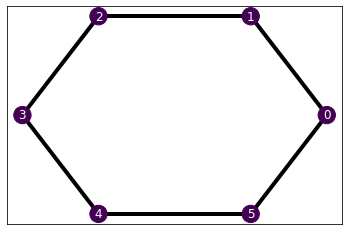

In [ ]:
H_ising.draw()

In the case of a lattice, we have created our own custom a square-lattice-like pattern which adapts to periodic boundary conditions. Let's first see how it looks with inhomogeneous parameters and without periodic boundary conditions.

In [ ]:
b, j = [0., 0.5, 1.], [0., 0.75, 1.5]
H_ising = IsingHamiltonian(lattice, b, j)

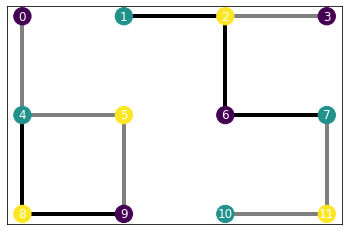

In [ ]:
H_ising.draw()

> Note: Notice here that we do not explicitly define the values of the interacting terms for every node and edge. The `Hamiltonian` takes care to replicate the pattern along the nodes and edges by order. The behaviour is consistent, although we do not recommend using this property unless you are confident it works as expected. It is mainly intended to perform simple patterns like homogeneous Hamiltonians, such as the one we defined before, or alternating exchange in one dimension.
In case you want to exploit it, we recommend paying close attention to the edge ordering. In the `Chain1D` the edges go in increasing order. In the `SquareLattice`, we sequentially parse the lattice rows from left to right, and top to bottom. We start at the first node and create two edges: the horizontal towards the right and the vertical downwards. This takes into account periodic boundary conditions.

Let's see now a lattice with periodic boundary conditions! (We're proud of this plotting :3) 

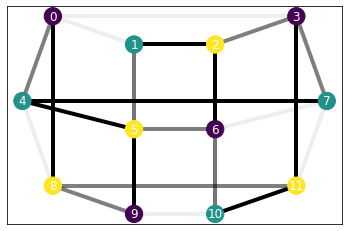

In [ ]:
lattice = SquareLattice(3, 4)
b, j = [0., 0.5, 1.], [0.1, 0.75, 1.5]
H_ising = IsingHamiltonian(lattice, b, j)
H_ising.draw()

### Heisenberg models

In the presented work, we study a special case of the Heisenberg XY model. The quantum Heisenberg XY model is given by $$H=\sum_{i} J_{i}((1+\gamma)\sigma_{i}^x \sigma_{i+1}^x + (1-\gamma)\sigma_{i}^y \sigma_{i+1}^y) + \sum_{i}B_{i}\sigma_{i}^z,$$ 
where $J_i$ is the pair-wise antiferromagnetic exchange and $B_i$ is the strength of the on-site magnetic field. The parameter $\gamma$ induces an anisotropic interaction between directions $x$ and $y$. In the limit of $\gamma=0$, we have the so-called XX model $$H=\sum_{i} J_{i}(\sigma_{i}^x \sigma_{i+1}^x + \sigma_{i}^y \sigma_{i+1}^y) + \sum_{i}B_{i}\sigma_{i}^z\,,$$ whose results we report on the work [Certificates of quantum many-body properties assisted by machine learning](https://arxiv.org/abs/2103.03830).

In [ ]:
#export
class XYHamiltonian(LocalHamiltonian):
    def __init__(self, graph, linear, quadratic, gamma):
        linear, quadratic = arrayfy(linear, graph.n_nodes), arrayfy(quadratic, graph.n_edges)
        one_body_terms = [(np.array([n]), linear[n]*self.z) for n in graph.nodes]
        two_body_terms = [(edge, self._2body(quadratic[e], gamma))
                          for e, edge in enumerate(graph.edges)]
        interactions = one_body_terms + two_body_terms
        super().__init__(graph, interactions, gamma)
        self.name = 'xy'
        
    def _2body(self, amplitude, gamma):
        return amplitude*((1+gamma)*self.x@self.x + (1-gamma)*self.y@self.y)

class XXHamiltonian(XYHamiltonian):
    def __init__(self, graph, linear, quadratic):
        super().__init__(graph, linear, quadratic, gamma=0.)
        self.name = 'xx'
        self.aux_args = []

In [ ]:
xy = XYHamiltonian(chain, 0.5, 1., 0.2)
xy.interactions

[(array([0]), <2×2 Real Constant: 0.5·z>),
 (array([1]), <2×2 Real Constant: 0.5·z>),
 (array([2]), <2×2 Real Constant: 0.5·z>),
 (array([3]), <2×2 Real Constant: 0.5·z>),
 (array([4]), <2×2 Real Constant: 0.5·z>),
 (array([5]), <2×2 Real Constant: 0.5·z>),
 (array([0, 1]), <4×4 Complex Constant: 1.2·x⊗x + 0.8·y⊗y>),
 (array([1, 2]), <4×4 Complex Constant: 1.2·x⊗x + 0.8·y⊗y>),
 (array([2, 3]), <4×4 Complex Constant: 1.2·x⊗x + 0.8·y⊗y>),
 (array([3, 4]), <4×4 Complex Constant: 1.2·x⊗x + 0.8·y⊗y>),
 (array([4, 5]), <4×4 Complex Constant: 1.2·x⊗x + 0.8·y⊗y>),
 (array([0, 5]), <4×4 Complex Constant: 1.2·x⊗x + 0.8·y⊗y>)]

In [ ]:
xx = XXHamiltonian(chain, 0.5, 1.)
xx.interactions

[(array([0]), <2×2 Real Constant: 0.5·z>),
 (array([1]), <2×2 Real Constant: 0.5·z>),
 (array([2]), <2×2 Real Constant: 0.5·z>),
 (array([3]), <2×2 Real Constant: 0.5·z>),
 (array([4]), <2×2 Real Constant: 0.5·z>),
 (array([5]), <2×2 Real Constant: 0.5·z>),
 (array([0, 1]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([1, 2]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([2, 3]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([3, 4]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([4, 5]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([0, 5]), <4×4 Complex Constant: x⊗x + y⊗y>)]

For completeness, we provide an additional example of the Heisenberg Hamiltonian including interaction in the $\sigma^z$ direction $$H=\sum_i J_i(\sigma_{i}^x\sigma_{i+1}^x + \sigma_{i}^y\sigma_{i+1}^y + \sigma_{i}^z\sigma_{i+1}^z) + \sum_i B_i\sigma_i^z$$
This model, with $B_i=0 \ \forall i$, is used in [[1]](https://iopscience.iop.org/article/10.1088/1742-6596/1163/1/012057). See the <a href="https://borjarequena.github.io/BOUNCE/sdp.html">SdP docs</a> for further details.

In [ ]:
#export 
class XYZHamiltonian(LocalHamiltonian):
    def __init__(self, graph, linear, quadratic):
        linear, quadratic = arrayfy(linear, graph.n_nodes), arrayfy(quadratic, graph.n_edges)
        one_body_terms = [(np.array([n]), linear[n]*self.z) for n in graph.nodes]
        two_body_terms = [(edge, self._2body(quadratic[e])) for e, edge in enumerate(graph.edges)]
        interactions = one_body_terms + two_body_terms
        super().__init__(graph, interactions)
        self.name = 'xyz'
        
    def _2body(self, amplitude):
        return amplitude*(self.x@self.x + self.y@self.y + self.z@self.z)

In [ ]:
xyz = XYZHamiltonian(chain, 0.5, 1.5)
xyz.interactions

[(array([0]), <2×2 Real Constant: 0.5·z>),
 (array([1]), <2×2 Real Constant: 0.5·z>),
 (array([2]), <2×2 Real Constant: 0.5·z>),
 (array([3]), <2×2 Real Constant: 0.5·z>),
 (array([4]), <2×2 Real Constant: 0.5·z>),
 (array([5]), <2×2 Real Constant: 0.5·z>),
 (array([0, 1]), <4×4 Complex Constant: 1.5·(x⊗x + y⊗y + z⊗z)>),
 (array([1, 2]), <4×4 Complex Constant: 1.5·(x⊗x + y⊗y + z⊗z)>),
 (array([2, 3]), <4×4 Complex Constant: 1.5·(x⊗x + y⊗y + z⊗z)>),
 (array([3, 4]), <4×4 Complex Constant: 1.5·(x⊗x + y⊗y + z⊗z)>),
 (array([4, 5]), <4×4 Complex Constant: 1.5·(x⊗x + y⊗y + z⊗z)>),
 (array([0, 5]), <4×4 Complex Constant: 1.5·(x⊗x + y⊗y + z⊗z)>)]

### Serializing

There are some issues serializing `picos.Expressions`. In our Hamiltonians we find `picos.ComplexAffineExpressions`, which are unpicklable. Hence, this restricts the way we can copy as well as save and load the Hamiltonians. 

For this reason, we have defined a `Hamiltonian.__deepcopy__` method, which returns a deep copy of all the parameters except for a shallow copy of the interactions. Furthermore, we have defined a `LocalHamiltonian.__reduce__` method that allows us to serielize local Hamiltonians. This allows us to both deepcopy and save/load local Hamiltonians. However, all local Hamiltonians must be initialized with the syntax `LocalHamiltonian(graph, one_body_amplitudes, two_body_amplitudes, *auxiliary_args)`. 

In [ ]:
fun, args = xx.__reduce__()
fun, args

(__main__.XXHamiltonian,
 (<__main__.Chain1D at 0x7fdfb2213690>,
  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))

In [ ]:
xx_new = fun(*args)
xx_new.interactions

[(array([0]), <2×2 Real Constant: 0.5·z>),
 (array([1]), <2×2 Real Constant: 0.5·z>),
 (array([2]), <2×2 Real Constant: 0.5·z>),
 (array([3]), <2×2 Real Constant: 0.5·z>),
 (array([4]), <2×2 Real Constant: 0.5·z>),
 (array([5]), <2×2 Real Constant: 0.5·z>),
 (array([0, 1]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([1, 2]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([2, 3]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([3, 4]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([4, 5]), <4×4 Complex Constant: x⊗x + y⊗y>),
 (array([0, 5]), <4×4 Complex Constant: x⊗x + y⊗y>)]

In [ ]:
assert xx.interactions == xx_new.interactions

With the `__reduce__` method we can also deepcopy the Hamiltonians.

In [ ]:
xx_copy = deepcopy(xx)

In [ ]:
assert xx.interactions == xx_copy.interactions

The only issue with the way we have implemented the `__reduce__` method is that, whenever the parent class has more input arguments than the child one, we need to manually fix it in the child one. For instance, `XYHamiltonian` takes the input `gamma`, but the `XXHamiltonian`, which inherits from the first one, does not have any additional argument besides the graph, the linear and the quadratic terms. In this case, we have to set `XXHamiltonian.aux_args = []` after calling `super().__init__` in the `XXHamiltonian.__init__`. Otherwise, the serializer will break due to an excess of input arguments trying to feed `gamma` into `XXHamiltonian`.

## References
[1] F. Uskov and O. Lychkovskiy. [A variational lower bound on the ground state of a many-body system and the squaring parametrization of density matrices](https://iopscience.iop.org/article/10.1088/1742-6596/1163/1/012057). *Journal of Physics: Conference Series* **1163** 012057 (2019)

## Export-

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_environment.ipynb.
Converted 01_agents.ipynb.
Converted 02_budget_profiles.ipynb.
Converted 03_hamiltonian.ipynb.
Converted 04_training.ipynb.
Converted 05_utils.ipynb.
Converted 06_sdp.ipynb.
Converted index.ipynb.
